# NIN（网络中的网络）

LeNet、AlexNet和VGG都有一个共同的设计模式：通过一系列的卷积层与汇聚层来提取空间结构特征；然后通过全连接层对特征的表征进行处理。

AlexNet和VGG对LeNet的改进主要在于如何扩大和加深这两个模块

全连接的问题
全连接层的参数特别占用空间 整个网络的参数都在全连接层

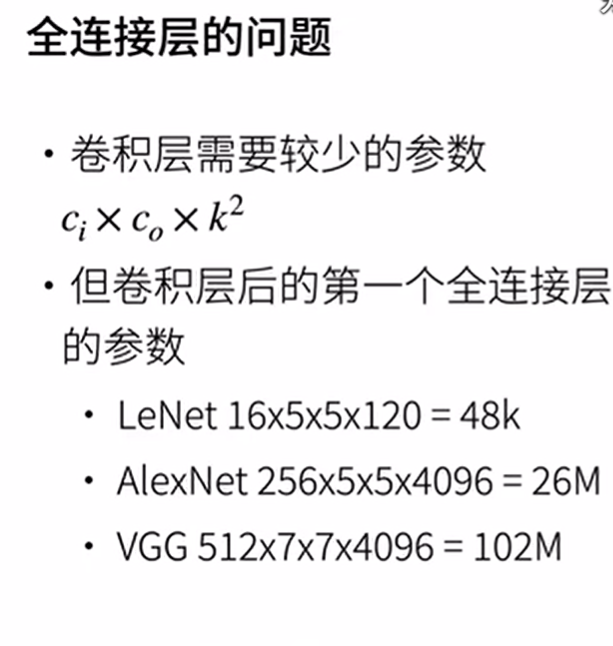

# NIN块
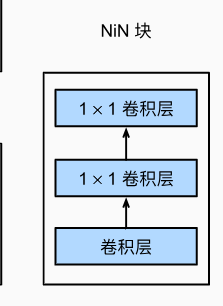

一个卷积层后接上两个卷积层（也就是1x1的全连接层）

NiN块以一个普通卷积层开始，后面是两个1x1的卷积层
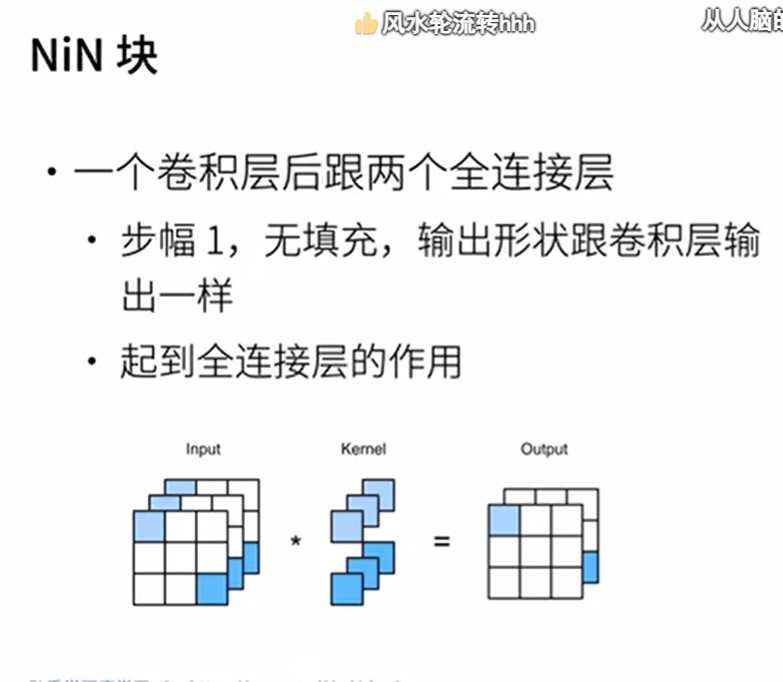

# NIN架构

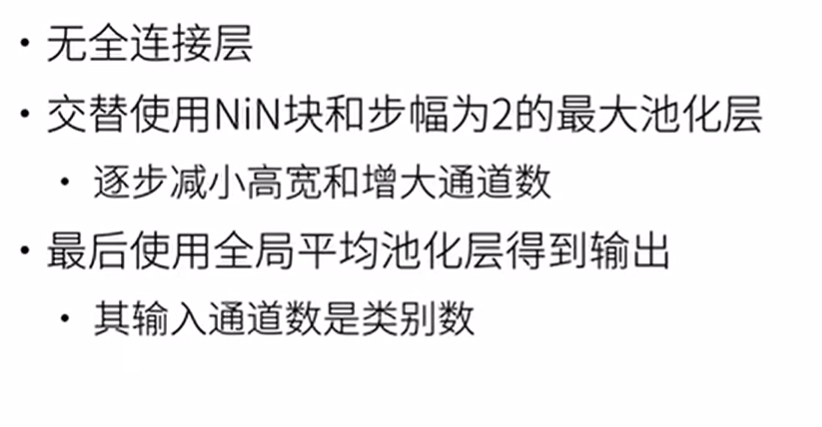

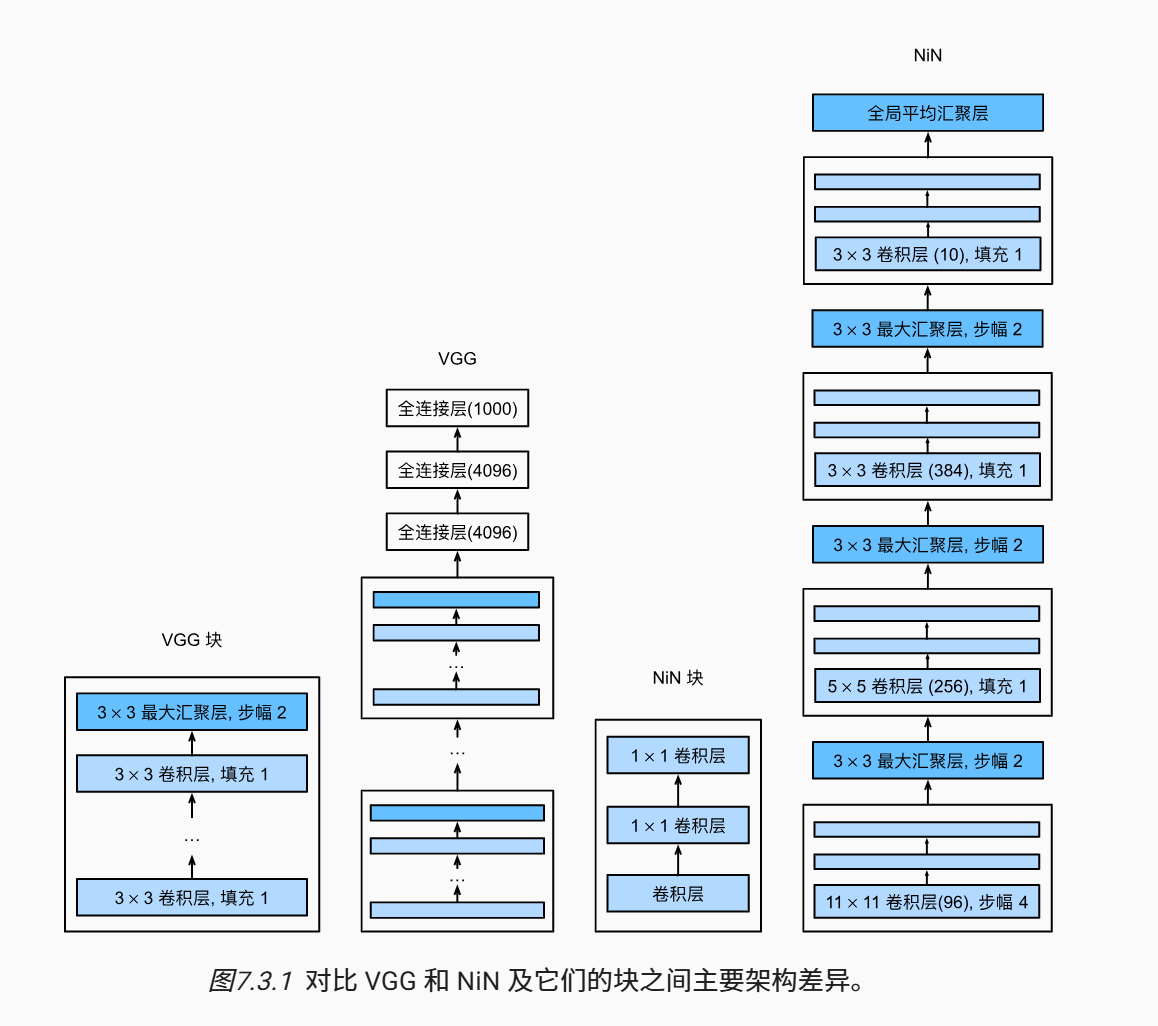

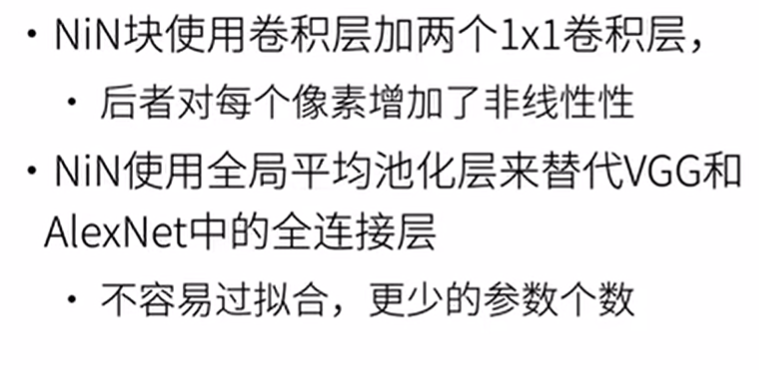

In [1]:
#网络中的网络 NIN
import torch
from torch import nn
from d2l import torch as d2l

#先实现NIN的块
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        # 第一个卷积层
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        # 第二个卷积层，1x1卷积核
        nn.Conv2d(out_channels, out_channels, kernel_size=1), 
        nn.ReLU(),
        # 第三个卷积层，1x1卷积核
        nn.Conv2d(out_channels, out_channels, kernel_size=1), 
        nn.ReLU()
    )

In [4]:
#NIN的模型
net = nn.Sequential(
    # 第一层：NIN block + MaxPooling
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(kernel_size=3, stride=2),

    # 第二层：NIN block + MaxPooling
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(kernel_size=3, stride=2),

    # 第三层：NIN block + MaxPooling
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(kernel_size=3, stride=2),

    # Dropout 层，用于防止过拟合
    nn.Dropout(0.5),

    # 第四层：NIN block，输出类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),

    # 自适应平均池化，将输出特征图变为1x1
    nn.AdaptiveAvgPool2d((1, 1)),

    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten()
)


In [5]:
# 我们创建一个数据样本来查看每个块的输出形状
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


loss 0.378, train acc 0.859, test acc 0.862
1601.5 examples/sec on cuda:0


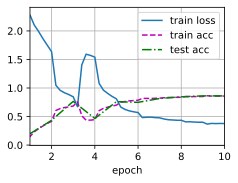

In [6]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

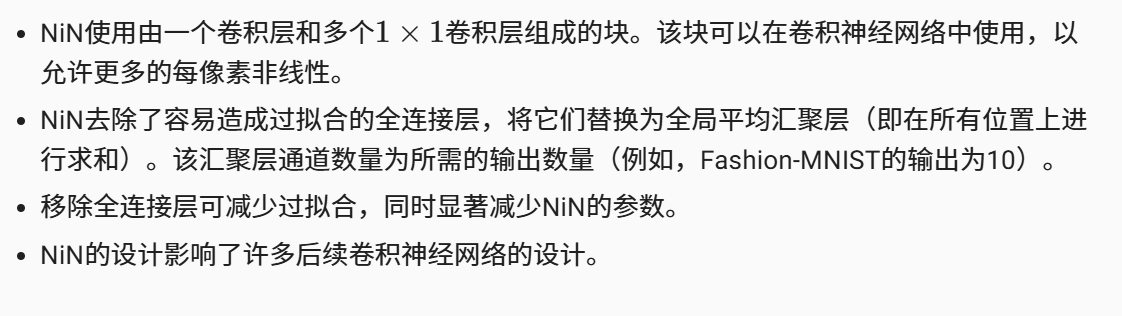